In [1]:
import tensorflow as tf
from sklearn.model_selection import KFold

from IPython.display import clear_output
import matplotlib.pyplot as plt

import time
import os

import pandas as pd
# General
from glob import glob
import resource
from tqdm.notebook import tqdm
import shutil

# Data Handling
import numpy as np
import pandas as pd
import json

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
tfr_files = glob("../input/hubmap-image-dataset/*.tfrecords")
tfr_files

['../input/hubmap-image-dataset/095bf7a1f_1.tfrecords',
 '../input/hubmap-image-dataset/0486052bb_1.tfrecords',
 '../input/hubmap-image-dataset/2f6ecfcdf_1.tfrecords',
 '../input/hubmap-image-dataset/e79de561c_1.tfrecords',
 '../input/hubmap-image-dataset/1e2425f28_1.tfrecords',
 '../input/hubmap-image-dataset/aaa6a05cc_1.tfrecords',
 '../input/hubmap-image-dataset/cb2d976f4_1.tfrecords',
 '../input/hubmap-image-dataset/54f2eec69_1.tfrecords']

In [3]:
def get_image_from_example(raw_example):
    parsed = tf.train.Example.FromString(raw_example.numpy())
    
    target_bytes_string = parsed.features.feature['target'].bytes_list.value[0]
    image_bytes_string = parsed.features.feature['image'].bytes_list.value[0]
    
    mask = np.frombuffer(target_bytes_string, dtype='<f4').reshape(256,256, 1)
    input_image = np.frombuffer(image_bytes_string, dtype='<f4').reshape(256,256,3)
    
    return mask, input_image

In [4]:
def batch_generator(dataset, epochs, batch_size):
    batched_dataset = dataset.batch(batch_size)
    for epoch in range(epochs):
        for batch in batched_dataset:
            image_list = []
            target_list = []

            for example in batch:
                target, input_image = get_image_from_example(example)

                image_list.append(input_image)
                target_list.append(target)
            image_list = np.stack(image_list)
            target_list = np.stack(target_list)

            yield (image_list, target_list)

## Define the model

In [5]:
OUTPUT_CHANNELS = 0

In [6]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [7]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [8]:
def Generator():
    
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='sigmoid')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model

In [9]:
def generate_images(input_image, mask):    

    pred = generator.predict(input_image.copy()[np.newaxis, ...]).reshape(1, 256,256)
    
    loss = dice_coef(pred, mask).numpy()

    print(loss)

    # Plot
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)

    plt.subplot(1, 3, 2)
    plt.imshow(mask[0])

    plt.subplot(1, 3, 3)
    plt.imshow(pred[0])

    plt.show()
    
    return input_image, mask, loss

In [10]:
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

In [11]:
def get_generator():
    strategy = tf.distribute.MirroredStrategy()
  # strategy = tf.distribute.TPUStrategy(resolver)

    with strategy.scope():
        generator = Generator()
        generator_optimizer = tf.keras.optimizers.Adam(2e-2, beta_1=0.5)

    def dice_coef(a, b, smooth=1e-5):
        sum_a = tf.reduce_sum(a, [1,2])
        sum_b = tf.reduce_sum(b, [1,2])
      
        join_sum = tf.reduce_sum(tf.multiply(a, b,), [1,2])

      # print(sum_a)
      # print(sum_b)
      # print(join_sum)

        dice = 1-(join_sum*2+smooth)/(sum_a+sum_b+smooth)

        dice = tf.math.reduce_mean(dice)
      
        return dice
      
    generator.compile(generator_optimizer,dice_coef)

    return generator

In [12]:
kf = KFold(4, shuffle=True)

In [13]:
batch_size = 20
epochs = 20
steps_per_epoch = int(6000/batch_size)
val_epochs = (200*200//2000)
checkpoint_filepath = "checkpoints/"

In [14]:
if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints/')

300/300 [==============================] - 79s 234ms/step - loss: 0.4300 - val_loss: 0.7610
Saving model
300/300 [==============================] - 51s 171ms/step - loss: 0.2897 - val_loss: 0.4536
Saving model
300/300 [==============================] - 51s 170ms/step - loss: 0.1186 - val_loss: 0.2207
Saving model
300/300 [==============================] - 51s 171ms/step - loss: 0.1144 - val_loss: 0.1282
Saving model
300/300 [==============================] - 51s 170ms/step - loss: 0.1056 - val_loss: 0.3157


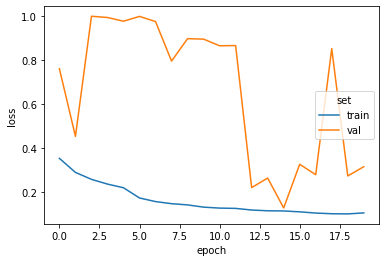

300/300 [==============================] - 63s 189ms/step - loss: 0.5002 - val_loss: 0.5516
Saving model
300/300 [==============================] - 51s 171ms/step - loss: 0.1416 - val_loss: 0.2465
Saving model
300/300 [==============================] - 51s 170ms/step - loss: 0.1197 - val_loss: 0.1883
Saving model
300/300 [==============================] - 51s 170ms/step - loss: 0.0905 - val_loss: 0.2265


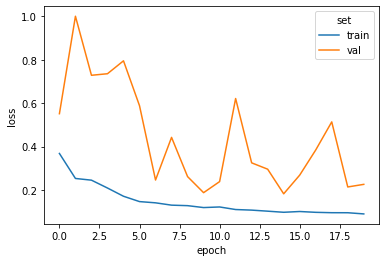

300/300 [==============================] - 60s 182ms/step - loss: 0.6225 - val_loss: 0.7732
Saving model
300/300 [==============================] - 52s 172ms/step - loss: 0.7691 - val_loss: 0.7614
Saving model
300/300 [==============================] - 51s 171ms/step - loss: 0.7691 - val_loss: 0.7656


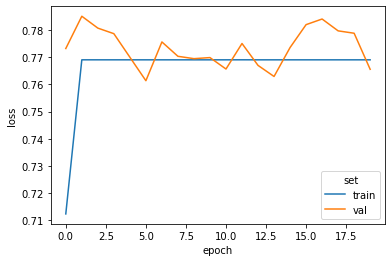

300/300 [==============================] - 62s 185ms/step - loss: 0.4469 - val_loss: 0.7929
Saving model
300/300 [==============================] - 51s 171ms/step - loss: 0.1925 - val_loss: 0.5425
Saving model
300/300 [==============================] - 51s 172ms/step - loss: 0.1353 - val_loss: 0.5360
Saving model
300/300 [==============================] - 51s 170ms/step - loss: 0.1116 - val_loss: 0.2692
Saving model
300/300 [==============================] - 51s 171ms/step - loss: 0.0859 - val_loss: 0.8063


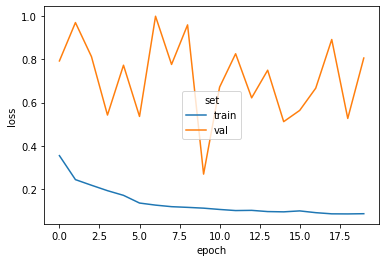

In [15]:
files = np.array(glob("../input/hubmap-image-dataset/*.tfrecords"))
for train_index, test_index in kf.split(files):
    train_set_id = ''.join(sorted(train_index.astype(str)))
    train_files = files[train_index]
    test_files = files[test_index]

    train = tf.data.TFRecordDataset(filenames = train_files)
    test = tf.data.TFRecordDataset(filenames=test_files)
    test_gen = batch_generator(test.shuffle(2000), epochs=val_epochs, batch_size=200)

    loss_df = []

    best_val_loss = 1

    generator = get_generator()

    for epoch in range(epochs):

        val_data = next(test_gen)

        history = generator.fit(batch_generator(train, 1, batch_size),
                                steps_per_epoch=steps_per_epoch,
                                epochs=1,
                                validation_data=val_data)
        history = history.history

        if history['val_loss'][0] < best_val_loss:
            best_val_loss = history['val_loss'][0]
            best_val_id = str(history['val_loss'][0]).split('.')[-1][:2]
            # Check for existing saved models
            saved_models = glob(f"{checkpoint_filepath}generator_{train_set_id}*")
            
            m = None
            if saved_models:
                m = saved_models[0]
                prev_score = int(m.split('/')[-1].split('_')[-1])
                
            else:
                prev_score = 100

            if prev_score > int(best_val_id):
                if m:
                    shutil.rmtree(m)
                print('Saving model')
                generator.save(f"{checkpoint_filepath}generator_{train_set_id}_{best_val_id}")

        loss_df += [[epoch, 'train', history['loss'][0]], [epoch, 'val', history['val_loss'][0]]]

    loss_df = pd.DataFrame(loss_df, columns=['epoch', 'set', 'loss'])

    sns.lineplot(data=loss_df, x='epoch', y='loss', hue='set')
    plt.show()

In [16]:
loss_list = []
for raw_example in test.take(10):
    target, input_image = get_image_from_example(raw_example)
    target = target.reshape((1, 256,256))
    _, _, loss = generate_images(input_image, target)
    loss_list.append(loss)

NameError: name 'dice_coef' is not defined

In [17]:
np.mean(loss_list)

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan